In [1]:
!pip install segmentation-models-pytorch

import os
from pathlib import Path
from typing import Optional

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch.utils.data import Dataset as BaseDataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.train import TrainEpoch, ValidEpoch
from segmentation_models_pytorch.utils.metrics import IoU, Fscore

from global_config import *
from models.configs_model.best_unet import *
from dataset.ship_dataset import ShipDataset
from losses.dice import NamedDiceLoss
from models.unet import UNet

from tqdm import trange

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: n

In [2]:
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True

In [8]:
df = pd.read_csv(TRAIN_LABEL_PATH)
COEF_DIF = int(len(df)* 0.15)
df.shape, COEF_DIF

((231723, 2), 34758)

In [9]:

df = pd.read_csv(TRAIN_LABEL_PATH, nrows=COEF_DIF)

num_nan_sample = min([int(len(df) * 0.3)])
nan_samples = df[df["EncodedPixels"].isna()]
drop_subset = nan_samples.sample(n=num_nan_sample, random_state=42)
df = df.drop(drop_subset.index)
df = df.groupby("ImageId")["EncodedPixels"].apply(list).reset_index()

df

,ImageId,EncodedPixels
0,0001124c7.jpg,[nan]
1,000155de5.jpg,[264661 17 265429 33 266197 33 266965 33 26773...
2,000194a2d.jpg,[360486 1 361252 4 362019 5 362785 8 363552 10...
3,0001b1832.jpg,[nan]
4,00021ddc3.jpg,[108287 1 109054 3 109821 4 110588 5 111356 5 ...
...,...,...
18567,267d50b0a.jpg,[nan]
18568,267d96c47.jpg,[nan]
18569,267ea3a94.jpg,[nan]
18570,267ee13b0.jpg,[184723 1 185489 4 186256 5 187023 7 187790 9 ...


In [12]:
train_transform = A.Compose([
    A.Resize(height=HEIGHT, width=WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.05,
        rotate_limit=15,
        border_mode=0,
        p=0.5
    ),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=HEIGHT, width=WIDTH),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [14]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_df

,ImageId,EncodedPixels
9402,138a86e01.jpg,[nan]
16894,232fd547d.jpg,[466597 1 467364 3 468131 5 468898 7 469665 9 ...
18488,2656f2c35.jpg,[nan]
12301,198f62869.jpg,[nan]
7363,0f592c669.jpg,[485487 3 486250 8 487013 13 487775 19 488538 ...
...,...,...
11284,178114eca.jpg,[442894 2 443660 4 444426 7 445191 10 445957 1...
11964,18d85c16d.jpg,[nan]
5390,0b38fd344.jpg,[nan]
860,01bcd7b61.jpg,[363718 1 364485 4 365253 5 366020 8 366789 8 ...


In [15]:
train_dataset = ShipDataset(train_df, TRAIN_SAMPLE_DIR, train_transform)
valid_dataset = ShipDataset(val_df, TRAIN_SAMPLE_DIR, val_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
from torch.optim import Adam


model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=WEIGHT,
    classes=CLASSES,
    activation=activation,
    encoder_depth=ENCODER_DEPTH,
    # encoder_channel=ENCODER_CHANNELS,
).to(DEVICE)

optimizer = Adam(model.parameters(), lr=LR)

trainer = UNet(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=DEVICE
)
trainer.train(save_path=OUTPUT_UNET)

config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/50

train: 100%|██████████| 233/233 [07:29<00:00,  1.93s/it, dice_loss - 0.9957, iou_score - 0.1502, fscore - 0.5853]

valid: 100%|██████████| 59/59 [01:03<00:00,  1.08s/it, dice_loss - 0.9951, iou_score - 0.1932, fscore - 0.6646]

Epochs:   2%|▏         | 1/50 [08:33<6:59:12, 513.32s/it]


Train Loss: 0.9957, IoU: 0.1502, Fscore: 0.5853
Valid Loss: 0.9951, IoU: 0.1932, Fscore: 0.6646
✅ Best model saved (Fscore = 0.6646)

Epoch 2/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9953, iou_score - 0.2011, fscore - 0.6658]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.44it/s, dice_loss - 0.9949, iou_score - 0.2692, fscore - 0.759] 

Epochs:   4%|▍         | 2/50 [14:54<5:48:36, 435.77s/it]


Train Loss: 0.9953, IoU: 0.2011, Fscore: 0.6658
Valid Loss: 0.9949, IoU: 0.2692, Fscore: 0.7590
✅ Best model saved (Fscore = 0.7590)

Epoch 3/50

train: 100%|██████████| 233/233 [05:39<00:00,  1.46s/it, dice_loss - 0.9952, iou_score - 0.2323, fscore - 0.7103]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.45it/s, dice_loss - 0.9948, iou_score - 0.223, fscore - 0.7088] 

Epochs:   6%|▌         | 3/50 [21:14<5:21:20, 410.23s/it]


Train Loss: 0.9952, IoU: 0.2323, Fscore: 0.7103
Valid Loss: 0.9948, IoU: 0.2230, Fscore: 0.7088

Epoch 4/50

train: 100%|██████████| 233/233 [05:42<00:00,  1.47s/it, dice_loss - 0.9952, iou_score - 0.2505, fscore - 0.7297]

valid: 100%|██████████| 59/59 [00:41<00:00,  1.43it/s, dice_loss - 0.9948, iou_score - 0.299, fscore - 0.7933]

Epochs:   8%|▊         | 4/50 [27:38<5:06:31, 399.82s/it]


Train Loss: 0.9952, IoU: 0.2505, Fscore: 0.7297
Valid Loss: 0.9948, IoU: 0.2990, Fscore: 0.7933
✅ Best model saved (Fscore = 0.7933)

Epoch 5/50

train: 100%|██████████| 233/233 [05:43<00:00,  1.47s/it, dice_loss - 0.9952, iou_score - 0.2629, fscore - 0.7409]

valid: 100%|██████████| 59/59 [00:41<00:00,  1.42it/s, dice_loss - 0.9948, iou_score - 0.3065, fscore - 0.7989]

Epochs:  10%|█         | 5/50 [34:03<4:55:48, 394.41s/it]


Train Loss: 0.9952, IoU: 0.2629, Fscore: 0.7409
Valid Loss: 0.9948, IoU: 0.3065, Fscore: 0.7989
✅ Best model saved (Fscore = 0.7989)

Epoch 6/50

train: 100%|██████████| 233/233 [05:43<00:00,  1.48s/it, dice_loss - 0.9952, iou_score - 0.2587, fscore - 0.741]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.47it/s, dice_loss - 0.9948, iou_score - 0.2297, fscore - 0.719]

Epochs:  12%|█▏        | 6/50 [40:27<4:46:34, 390.79s/it]


Train Loss: 0.9952, IoU: 0.2587, Fscore: 0.7410
Valid Loss: 0.9948, IoU: 0.2297, Fscore: 0.7190

Epoch 7/50

train: 100%|██████████| 233/233 [05:42<00:00,  1.47s/it, dice_loss - 0.9952, iou_score - 0.2723, fscore - 0.7497]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.45it/s, dice_loss - 0.9948, iou_score - 0.2937, fscore - 0.7892]

Epochs:  14%|█▍        | 7/50 [46:50<4:38:14, 388.23s/it]


Train Loss: 0.9952, IoU: 0.2723, Fscore: 0.7497
Valid Loss: 0.9948, IoU: 0.2937, Fscore: 0.7892

Epoch 8/50

train: 100%|██████████| 233/233 [05:38<00:00,  1.45s/it, dice_loss - 0.9951, iou_score - 0.2956, fscore - 0.7742]

valid: 100%|██████████| 59/59 [00:39<00:00,  1.48it/s, dice_loss - 0.9948, iou_score - 0.3044, fscore - 0.793]

Epochs:  16%|█▌        | 8/50 [53:08<4:29:35, 385.13s/it]


Train Loss: 0.9951, IoU: 0.2956, Fscore: 0.7742
Valid Loss: 0.9948, IoU: 0.3044, Fscore: 0.7930

Epoch 9/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3001, fscore - 0.7811]

valid: 100%|██████████| 59/59 [00:41<00:00,  1.44it/s, dice_loss - 0.9948, iou_score - 0.3007, fscore - 0.7925]

Epochs:  18%|█▊        | 9/50 [59:30<4:22:30, 384.15s/it]


Train Loss: 0.9951, IoU: 0.3001, Fscore: 0.7811
Valid Loss: 0.9948, IoU: 0.3007, Fscore: 0.7925

Epoch 10/50

train: 100%|██████████| 233/233 [05:41<00:00,  1.47s/it, dice_loss - 0.9951, iou_score - 0.3165, fscore - 0.8003]

valid: 100%|██████████| 59/59 [00:41<00:00,  1.43it/s, dice_loss - 0.9948, iou_score - 0.3559, fscore - 0.839]

Epochs:  20%|██        | 10/50 [1:05:53<4:15:51, 383.78s/it]


Train Loss: 0.9951, IoU: 0.3165, Fscore: 0.8003
Valid Loss: 0.9948, IoU: 0.3559, Fscore: 0.8390
✅ Best model saved (Fscore = 0.8390)

Epoch 11/50

train: 100%|██████████| 233/233 [05:38<00:00,  1.45s/it, dice_loss - 0.9951, iou_score - 0.3118, fscore - 0.7875]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.44it/s, dice_loss - 0.9948, iou_score - 0.2953, fscore - 0.7851]

Epochs:  22%|██▏       | 11/50 [1:12:13<4:08:37, 382.50s/it]


Train Loss: 0.9951, IoU: 0.3118, Fscore: 0.7875
Valid Loss: 0.9948, IoU: 0.2953, Fscore: 0.7851

Epoch 12/50

train: 100%|██████████| 233/233 [05:38<00:00,  1.45s/it, dice_loss - 0.9909, iou_score - 0.3031, fscore - 0.7816]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.46it/s, dice_loss - 0.9948, iou_score - 0.2558, fscore - 0.7406]

Epochs:  24%|██▍       | 12/50 [1:18:32<4:01:35, 381.45s/it]


Train Loss: 0.9909, IoU: 0.3031, Fscore: 0.7816
Valid Loss: 0.9948, IoU: 0.2558, Fscore: 0.7406

Epoch 13/50

train: 100%|██████████| 233/233 [05:39<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.2951, fscore - 0.7709]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.45it/s, dice_loss - 0.9948, iou_score - 0.2536, fscore - 0.7481]

Epochs:  26%|██▌       | 13/50 [1:24:52<3:55:04, 381.19s/it]


Train Loss: 0.9951, IoU: 0.2951, Fscore: 0.7709
Valid Loss: 0.9948, IoU: 0.2536, Fscore: 0.7481

Epoch 14/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3103, fscore - 0.7797]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.45it/s, dice_loss - 0.9948, iou_score - 0.3425, fscore - 0.8301]

Epochs:  28%|██▊       | 14/50 [1:31:14<3:48:46, 381.29s/it]


Train Loss: 0.9951, IoU: 0.3103, Fscore: 0.7797
Valid Loss: 0.9948, IoU: 0.3425, Fscore: 0.8301

Epoch 15/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3175, fscore - 0.7936]

valid: 100%|██████████| 59/59 [00:41<00:00,  1.42it/s, dice_loss - 0.9948, iou_score - 0.3072, fscore - 0.7999]

Epochs:  30%|███       | 15/50 [1:37:36<3:42:35, 381.59s/it]


Train Loss: 0.9951, IoU: 0.3175, Fscore: 0.7936
Valid Loss: 0.9948, IoU: 0.3072, Fscore: 0.7999

Epoch 16/50

train: 100%|██████████| 233/233 [05:42<00:00,  1.47s/it, dice_loss - 0.9951, iou_score - 0.3169, fscore - 0.7961]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.44it/s, dice_loss - 0.9948, iou_score - 0.3408, fscore - 0.8297]

Epochs:  32%|███▏      | 16/50 [1:43:59<3:36:30, 382.08s/it]


Train Loss: 0.9951, IoU: 0.3169, Fscore: 0.7961
Valid Loss: 0.9948, IoU: 0.3408, Fscore: 0.8297

Epoch 17/50

train: 100%|██████████| 233/233 [05:38<00:00,  1.45s/it, dice_loss - 0.9951, iou_score - 0.35, fscore - 0.8262]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.47it/s, dice_loss - 0.9948, iou_score - 0.3365, fscore - 0.8239]

Epochs:  34%|███▍      | 17/50 [1:50:18<3:29:34, 381.05s/it]


Train Loss: 0.9951, IoU: 0.3500, Fscore: 0.8262
Valid Loss: 0.9948, IoU: 0.3365, Fscore: 0.8239

Epoch 18/50

train: 100%|██████████| 233/233 [05:39<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.2891, fscore - 0.7683]

valid: 100%|██████████| 59/59 [00:39<00:00,  1.48it/s, dice_loss - 0.9948, iou_score - 0.302, fscore - 0.7867]

Epochs:  36%|███▌      | 18/50 [1:56:37<3:22:54, 380.46s/it]


Train Loss: 0.9951, IoU: 0.2891, Fscore: 0.7683
Valid Loss: 0.9948, IoU: 0.3020, Fscore: 0.7867

Epoch 19/50

train: 100%|██████████| 233/233 [05:44<00:00,  1.48s/it, dice_loss - 0.9951, iou_score - 0.2822, fscore - 0.7629]

valid: 100%|██████████| 59/59 [00:42<00:00,  1.38it/s, dice_loss - 0.9948, iou_score - 0.3024, fscore - 0.7955]

Epochs:  38%|███▊      | 19/50 [2:03:04<3:17:35, 382.43s/it]


Train Loss: 0.9951, IoU: 0.2822, Fscore: 0.7629
Valid Loss: 0.9948, IoU: 0.3024, Fscore: 0.7955

Epoch 20/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.2987, fscore - 0.7795]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.44it/s, dice_loss - 0.9948, iou_score - 0.3363, fscore - 0.823]

Epochs:  40%|████      | 20/50 [2:09:25<3:11:01, 382.04s/it]


Train Loss: 0.9951, IoU: 0.2987, Fscore: 0.7795
Valid Loss: 0.9948, IoU: 0.3363, Fscore: 0.8230

Epoch 21/50

train: 100%|██████████| 233/233 [05:39<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3033, fscore - 0.777]

valid: 100%|██████████| 59/59 [00:43<00:00,  1.37it/s, dice_loss - 0.9947, iou_score - 0.3211, fscore - 0.8145]

Epochs:  42%|████▏     | 21/50 [2:15:47<3:04:40, 382.09s/it]


Train Loss: 0.9951, IoU: 0.3033, Fscore: 0.7770
Valid Loss: 0.9947, IoU: 0.3211, Fscore: 0.8145

Epoch 22/50

train: 100%|██████████| 233/233 [06:02<00:00,  1.56s/it, dice_loss - 0.9951, iou_score - 0.3352, fscore - 0.8064]

valid: 100%|██████████| 59/59 [00:47<00:00,  1.23it/s, dice_loss - 0.9947, iou_score - 0.3884, fscore - 0.8629]

Epochs:  44%|████▍     | 22/50 [2:22:38<3:02:18, 390.67s/it]


Train Loss: 0.9951, IoU: 0.3352, Fscore: 0.8064
Valid Loss: 0.9947, IoU: 0.3884, Fscore: 0.8629
✅ Best model saved (Fscore = 0.8629)

Epoch 23/50

train: 100%|██████████| 233/233 [05:44<00:00,  1.48s/it, dice_loss - 0.9951, iou_score - 0.3435, fscore - 0.8137]

valid: 100%|██████████| 59/59 [00:39<00:00,  1.48it/s, dice_loss - 0.9947, iou_score - 0.3941, fscore - 0.8692]

Epochs:  46%|████▌     | 23/50 [2:29:03<2:54:58, 388.83s/it]


Train Loss: 0.9951, IoU: 0.3435, Fscore: 0.8137
Valid Loss: 0.9947, IoU: 0.3941, Fscore: 0.8692
✅ Best model saved (Fscore = 0.8692)

Epoch 24/50

train: 100%|██████████| 233/233 [05:38<00:00,  1.45s/it, dice_loss - 0.9951, iou_score - 0.3571, fscore - 0.8252]

valid: 100%|██████████| 59/59 [00:39<00:00,  1.48it/s, dice_loss - 0.9947, iou_score - 0.3475, fscore - 0.835]

Epochs:  48%|████▊     | 24/50 [2:35:21<2:47:11, 385.82s/it]


Train Loss: 0.9951, IoU: 0.3571, Fscore: 0.8252
Valid Loss: 0.9947, IoU: 0.3475, Fscore: 0.8350

Epoch 25/50

train: 100%|██████████| 233/233 [05:37<00:00,  1.45s/it, dice_loss - 0.9951, iou_score - 0.3208, fscore - 0.7887]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.47it/s, dice_loss - 0.9948, iou_score - 0.3533, fscore - 0.8356]

Epochs:  50%|█████     | 25/50 [2:41:39<2:39:46, 383.47s/it]


Train Loss: 0.9951, IoU: 0.3208, Fscore: 0.7887
Valid Loss: 0.9948, IoU: 0.3533, Fscore: 0.8356

Epoch 26/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.2849, fscore - 0.7607]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.44it/s, dice_loss - 0.9948, iou_score - 0.3084, fscore - 0.7985]

Epochs:  52%|█████▏    | 26/50 [2:48:01<2:33:09, 382.88s/it]


Train Loss: 0.9951, IoU: 0.2849, Fscore: 0.7607
Valid Loss: 0.9948, IoU: 0.3084, Fscore: 0.7985

Epoch 27/50

train: 100%|██████████| 233/233 [05:41<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3286, fscore - 0.8066]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.45it/s, dice_loss - 0.9947, iou_score - 0.358, fscore - 0.8413]

Epochs:  54%|█████▍    | 27/50 [2:54:23<2:26:39, 382.59s/it]


Train Loss: 0.9951, IoU: 0.3286, Fscore: 0.8066
Valid Loss: 0.9947, IoU: 0.3580, Fscore: 0.8413

Epoch 28/50

train: 100%|██████████| 233/233 [05:43<00:00,  1.47s/it, dice_loss - 0.9951, iou_score - 0.3173, fscore - 0.7972]

valid: 100%|██████████| 59/59 [00:42<00:00,  1.40it/s, dice_loss - 0.9947, iou_score - 0.3814, fscore - 0.8568]

Epochs:  56%|█████▌    | 28/50 [3:00:48<2:20:33, 383.33s/it]


Train Loss: 0.9951, IoU: 0.3173, Fscore: 0.7972
Valid Loss: 0.9947, IoU: 0.3814, Fscore: 0.8568

Epoch 29/50

train: 100%|██████████| 233/233 [05:41<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3522, fscore - 0.8306]

valid: 100%|██████████| 59/59 [00:42<00:00,  1.38it/s, dice_loss - 0.9947, iou_score - 0.3607, fscore - 0.8427]

Epochs:  58%|█████▊    | 29/50 [3:07:12<2:14:14, 383.55s/it]


Train Loss: 0.9951, IoU: 0.3522, Fscore: 0.8306
Valid Loss: 0.9947, IoU: 0.3607, Fscore: 0.8427

Epoch 30/50

train: 100%|██████████| 233/233 [05:42<00:00,  1.47s/it, dice_loss - 0.9951, iou_score - 0.344, fscore - 0.81]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.46it/s, dice_loss - 0.9947, iou_score - 0.3665, fscore - 0.8504]

Epochs:  60%|██████    | 30/50 [3:13:34<2:07:45, 383.25s/it]


Train Loss: 0.9951, IoU: 0.3440, Fscore: 0.8100
Valid Loss: 0.9947, IoU: 0.3665, Fscore: 0.8504

Epoch 31/50

train: 100%|██████████| 233/233 [05:42<00:00,  1.47s/it, dice_loss - 0.9951, iou_score - 0.3481, fscore - 0.8126]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.47it/s, dice_loss - 0.9947, iou_score - 0.3118, fscore - 0.8058]

Epochs:  62%|██████▏   | 31/50 [3:19:57<2:01:19, 383.11s/it]


Train Loss: 0.9951, IoU: 0.3481, Fscore: 0.8126
Valid Loss: 0.9947, IoU: 0.3118, Fscore: 0.8058

Epoch 32/50

train: 100%|██████████| 233/233 [05:41<00:00,  1.47s/it, dice_loss - 0.9951, iou_score - 0.3406, fscore - 0.816]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.47it/s, dice_loss - 0.9947, iou_score - 0.3681, fscore - 0.8481]

Epochs:  64%|██████▍   | 32/50 [3:26:19<1:54:47, 382.64s/it]


Train Loss: 0.9951, IoU: 0.3406, Fscore: 0.8160
Valid Loss: 0.9947, IoU: 0.3681, Fscore: 0.8481

Epoch 33/50

train: 100%|██████████| 233/233 [05:41<00:00,  1.47s/it, dice_loss - 0.9951, iou_score - 0.2829, fscore - 0.7508]

valid: 100%|██████████| 59/59 [00:42<00:00,  1.38it/s, dice_loss - 0.9948, iou_score - 0.314, fscore - 0.8082]

Epochs:  66%|██████▌   | 33/50 [3:32:43<1:48:33, 383.13s/it]


Train Loss: 0.9951, IoU: 0.2829, Fscore: 0.7508
Valid Loss: 0.9948, IoU: 0.3140, Fscore: 0.8082

Epoch 34/50

train: 100%|██████████| 233/233 [05:42<00:00,  1.47s/it, dice_loss - 0.9951, iou_score - 0.3301, fscore - 0.8118]

valid: 100%|██████████| 59/59 [00:41<00:00,  1.43it/s, dice_loss - 0.9947, iou_score - 0.3641, fscore - 0.8476]

Epochs:  68%|██████▊   | 34/50 [3:39:07<1:42:14, 383.40s/it]


Train Loss: 0.9951, IoU: 0.3301, Fscore: 0.8118
Valid Loss: 0.9947, IoU: 0.3641, Fscore: 0.8476

Epoch 35/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3506, fscore - 0.8218]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.45it/s, dice_loss - 0.9947, iou_score - 0.3894, fscore - 0.8604]

Epochs:  70%|███████   | 35/50 [3:45:28<1:35:38, 382.59s/it]


Train Loss: 0.9951, IoU: 0.3506, Fscore: 0.8218
Valid Loss: 0.9947, IoU: 0.3894, Fscore: 0.8604

Epoch 36/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3386, fscore - 0.8065]

valid: 100%|██████████| 59/59 [00:41<00:00,  1.43it/s, dice_loss - 0.9947, iou_score - 0.4291, fscore - 0.8877]

Epochs:  72%|███████▏  | 36/50 [3:51:49<1:29:11, 382.23s/it]


Train Loss: 0.9951, IoU: 0.3386, Fscore: 0.8065
Valid Loss: 0.9947, IoU: 0.4291, Fscore: 0.8877
✅ Best model saved (Fscore = 0.8877)

Epoch 37/50

train: 100%|██████████| 233/233 [05:41<00:00,  1.47s/it, dice_loss - 0.9951, iou_score - 0.3609, fscore - 0.8273]

valid: 100%|██████████| 59/59 [00:41<00:00,  1.42it/s, dice_loss - 0.9947, iou_score - 0.3366, fscore - 0.826]

Epochs:  74%|███████▍  | 37/50 [3:58:13<1:22:53, 382.59s/it]


Train Loss: 0.9951, IoU: 0.3609, Fscore: 0.8273
Valid Loss: 0.9947, IoU: 0.3366, Fscore: 0.8260

Epoch 38/50

train: 100%|██████████| 233/233 [05:41<00:00,  1.47s/it, dice_loss - 0.9951, iou_score - 0.3515, fscore - 0.8238]

valid: 100%|██████████| 59/59 [00:41<00:00,  1.41it/s, dice_loss - 0.9947, iou_score - 0.3438, fscore - 0.8263]

Epochs:  76%|███████▌  | 38/50 [4:04:36<1:16:35, 382.94s/it]


Train Loss: 0.9951, IoU: 0.3515, Fscore: 0.8238
Valid Loss: 0.9947, IoU: 0.3438, Fscore: 0.8263

Epoch 39/50

train: 100%|██████████| 233/233 [05:38<00:00,  1.45s/it, dice_loss - 0.9951, iou_score - 0.33, fscore - 0.8091]

valid: 100%|██████████| 59/59 [00:39<00:00,  1.49it/s, dice_loss - 0.9947, iou_score - 0.3202, fscore - 0.8089]

Epochs:  78%|███████▊  | 39/50 [4:10:54<1:09:56, 381.46s/it]


Train Loss: 0.9951, IoU: 0.3300, Fscore: 0.8091
Valid Loss: 0.9947, IoU: 0.3202, Fscore: 0.8089

Epoch 40/50

train: 100%|██████████| 233/233 [05:38<00:00,  1.45s/it, dice_loss - 0.9951, iou_score - 0.3352, fscore - 0.8055]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.45it/s, dice_loss - 0.9948, iou_score - 0.2364, fscore - 0.7241]

Epochs:  80%|████████  | 40/50 [4:17:14<1:03:29, 380.93s/it]


Train Loss: 0.9951, IoU: 0.3352, Fscore: 0.8055
Valid Loss: 0.9948, IoU: 0.2364, Fscore: 0.7241

Epoch 41/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3342, fscore - 0.8172]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.44it/s, dice_loss - 0.9947, iou_score - 0.3514, fscore - 0.8384]

Epochs:  82%|████████▏ | 41/50 [4:23:36<57:10, 381.16s/it]  


Train Loss: 0.9951, IoU: 0.3342, Fscore: 0.8172
Valid Loss: 0.9947, IoU: 0.3514, Fscore: 0.8384

Epoch 42/50

train: 100%|██████████| 233/233 [05:42<00:00,  1.47s/it, dice_loss - 0.9951, iou_score - 0.3406, fscore - 0.818]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.45it/s, dice_loss - 0.9947, iou_score - 0.4208, fscore - 0.8834]

Epochs:  84%|████████▍ | 42/50 [4:29:59<50:53, 381.67s/it]


Train Loss: 0.9951, IoU: 0.3406, Fscore: 0.8180
Valid Loss: 0.9947, IoU: 0.4208, Fscore: 0.8834

Epoch 43/50

train: 100%|██████████| 233/233 [05:41<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3522, fscore - 0.829]

valid: 100%|██████████| 59/59 [00:39<00:00,  1.48it/s, dice_loss - 0.9947, iou_score - 0.3761, fscore - 0.8564]

Epochs:  86%|████████▌ | 43/50 [4:36:20<44:30, 381.44s/it]


Train Loss: 0.9951, IoU: 0.3522, Fscore: 0.8290
Valid Loss: 0.9947, IoU: 0.3761, Fscore: 0.8564

Epoch 44/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3456, fscore - 0.8161]

valid: 100%|██████████| 59/59 [00:41<00:00,  1.43it/s, dice_loss - 0.9947, iou_score - 0.3921, fscore - 0.8681]

Epochs:  88%|████████▊ | 44/50 [4:42:41<38:08, 381.40s/it]


Train Loss: 0.9951, IoU: 0.3456, Fscore: 0.8161
Valid Loss: 0.9947, IoU: 0.3921, Fscore: 0.8681

Epoch 45/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3812, fscore - 0.8468]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.45it/s, dice_loss - 0.9947, iou_score - 0.4135, fscore - 0.8801]

Epochs:  90%|█████████ | 45/50 [4:49:02<31:46, 381.28s/it]


Train Loss: 0.9951, IoU: 0.3812, Fscore: 0.8468
Valid Loss: 0.9947, IoU: 0.4135, Fscore: 0.8801

Epoch 46/50

train: 100%|██████████| 233/233 [05:41<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3701, fscore - 0.8403]

valid: 100%|██████████| 59/59 [00:41<00:00,  1.41it/s, dice_loss - 0.9947, iou_score - 0.4073, fscore - 0.8735]

Epochs:  92%|█████████▏| 46/50 [4:55:25<25:27, 381.80s/it]


Train Loss: 0.9951, IoU: 0.3701, Fscore: 0.8403
Valid Loss: 0.9947, IoU: 0.4073, Fscore: 0.8735

Epoch 47/50

train: 100%|██████████| 233/233 [05:41<00:00,  1.47s/it, dice_loss - 0.9951, iou_score - 0.3326, fscore - 0.8025]

valid: 100%|██████████| 59/59 [00:41<00:00,  1.43it/s, dice_loss - 0.9948, iou_score - 0.3271, fscore - 0.8146]

Epochs:  94%|█████████▍| 47/50 [5:01:48<19:06, 382.15s/it]


Train Loss: 0.9951, IoU: 0.3326, Fscore: 0.8025
Valid Loss: 0.9948, IoU: 0.3271, Fscore: 0.8146

Epoch 48/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.295, fscore - 0.7586]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.45it/s, dice_loss - 0.9947, iou_score - 0.3731, fscore - 0.8522]

Epochs:  96%|█████████▌| 48/50 [5:08:09<12:43, 381.83s/it]


Train Loss: 0.9951, IoU: 0.2950, Fscore: 0.7586
Valid Loss: 0.9947, IoU: 0.3731, Fscore: 0.8522

Epoch 49/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3562, fscore - 0.8303]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.47it/s, dice_loss - 0.9947, iou_score - 0.3742, fscore - 0.8524]

Epochs:  98%|█████████▊| 49/50 [5:14:29<06:21, 381.42s/it]


Train Loss: 0.9951, IoU: 0.3562, Fscore: 0.8303
Valid Loss: 0.9947, IoU: 0.3742, Fscore: 0.8524

Epoch 50/50

train: 100%|██████████| 233/233 [05:40<00:00,  1.46s/it, dice_loss - 0.9951, iou_score - 0.3321, fscore - 0.8073]

valid: 100%|██████████| 59/59 [00:40<00:00,  1.46it/s, dice_loss - 0.9947, iou_score - 0.3585, fscore - 0.8415]

Epochs: 100%|██████████| 50/50 [5:20:50<00:00, 385.00s/it]


Train Loss: 0.9951, IoU: 0.3321, Fscore: 0.8073
Valid Loss: 0.9947, IoU: 0.3585, Fscore: 0.8415


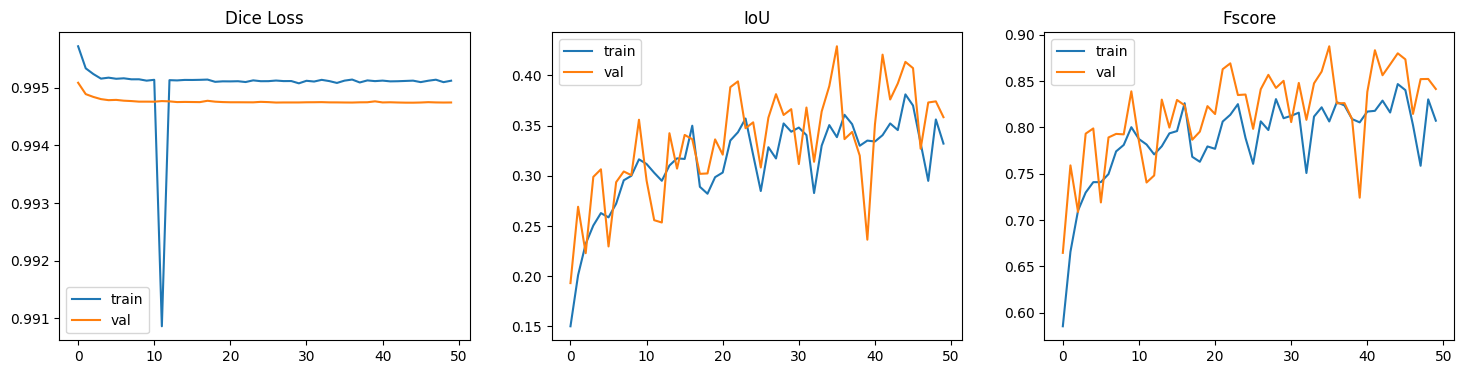

In [17]:
trainer.plot_metrics()